"Advanced_Fitting_of_Hydrolysis_Data" explored what the hydrolysis parameters were if $K_T, K_D, K_P$. values were known (ie, same as known experimental values for kinesin motors). 

In this code, we write a generative model to infer the parameters $\gamma, K_T, K_D, K_P$. 

This code is heavily based off of Justin Bois' code.

In [1]:
# Imports 
import logging
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)

import numpy as np
import pandas as pd

import cmdstanpy
import arviz as az

import iqplot
import bebi103

import bokeh.io
import bokeh.plotting

# bokeh.io.output_notebook()

# Import seaborn for aesthetic plots 
import seaborn as sns

from tqdm.notebook import tqdm

import pandas as pd
import ast

from bokeh.plotting import figure, show, curdoc
from bokeh.io import output_notebook
from bokeh.layouts import gridplot
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import ColorBar
from bokeh.transform import linear_cmap
from bokeh.palettes import Viridis256
from bokeh.themes import Theme
from bokeh.layouts import column, row

import scipy as sp
import matplotlib.pyplot as plt

import scipy.stats as st

# Plotting params
size = 500;

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/mashok/opt/anaconda3/envs/bebi103/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


In [2]:
# Read data 

data_location = '../../analyzed_data/atp-hydro/ATP.csv';
# Read the CSV file into a DataFrame
df1 = pd.read_csv(data_location); 

data_location = '../../analyzed_data/atp-hydro/ADP.csv';
# Read the CSV file into a DataFrame
df2 = pd.read_csv(data_location); 

data_location = '../../analyzed_data/atp-hydro/Phosphate.csv';
# Read the CSV file into a DataFrame
df3 = pd.read_csv(data_location); 

#### ------------- Load and Read Data ------------- ####
ATP_conc_list = []
ADP_conc_list = []
P_conc_list = []
ATP_curve_list = []
ratio_curve_list = []
linear_r2_list = []
exponential_r2_list = []
linear_hydrolysis_rate_list = []
exponential_hydrolysis_rate_list = []
times_list = []
data_locations_list = []

for df in [df1]:
# for df in [df1, df2, df3]: 
    # ATP Concentrations
    ATP_conc_list.append(np.array(df["ATP Concentration (uM)"])); 

    # ADP Concentrations
    ADP_conc_list.append(np.array(df["ADP Concentration (uM)"])); 

    # Phosphate Concentrations
    P_conc_list.append(np.array(df["P Concentration (uM)"])); 

    # ATP Curves
    ATP_curve_list.append([ast.literal_eval(df["ATP Curve (uM)"][i]) for i in range(len(df))])

    # Ratio Curves
    ratio_curve_list.append([ast.literal_eval(df["Ratio (A.U.)"][i]) for i in range(len(df))])

    # Goodness of Fit
    linear_r2_list.append(np.array(df["r-squared for linear fit"])); 
    exponential_r2_list.append(np.array(df["r-squared for exponential fit"])); 

    # Hydrolysis Rate
    linear_hydrolysis_rate_list.append(np.array(df["Hydrolysis Rate (uM/s/motor) from Linear Fitting (-abs(Slope)/Motconc)"])); 
    exponential_hydrolysis_rate_list.append(np.array(df["Hydrolysis Rate (uM/s/motor) from Exponential Curve"])); 

    # Time
    times_list.append([ast.literal_eval(df["Time Array (s)"][i]) for i in range(len(df))])
    
    # Data location
    data_locations_list.append(df["Data Location"])

    
times_list = [item for sublist in times_list for item in sublist];
ATP_conc_list = [item for sublist in ATP_conc_list for item in sublist]; 
ADP_conc_list = [item for sublist in ADP_conc_list for item in sublist];
P_conc_list = [item for sublist in P_conc_list for item in sublist];
ATP_curve_list = [item for sublist in ATP_curve_list for item in sublist];
ratio_curve_list = [item for sublist in ratio_curve_list for item in sublist];
linear_r2_list = [item for sublist in linear_r2_list for item in sublist];
exponential_r2_list = [item for sublist in exponential_r2_list for item in sublist];
linear_hydrolysis_rate_list = [item for sublist in linear_hydrolysis_rate_list for item in sublist];
exponential_hydrolysis_rate_list = [item for sublist in exponential_hydrolysis_rate_list for item in sublist];
data_locations_list = [item for sublist in data_locations_list for item in sublist]; 

In [3]:
plot1 = figure(title="ATP curves vs Time", width=size, height=size)

plot2 = figure(title="dATP/dt curves vs Time", width=size, height=size)

# gaussian_filter = lambda x: 
for i in range(len(ATP_curve_list)): 
    
    # Generate a color
    color = plt.cm.viridis(ATP_conc_list[i]/1410);
    color = "#{:02x}{:02x}{:02x}".format(int(color[0] * 255),
                                         int(color[1] * 255),
                                         int(color[2] * 255))
            
    plot1.line(times_list[i], ATP_curve_list[i], line_color=color, line_dash="dotted")
    plot2.line(times_list[i][5:], sp.ndimage.gaussian_filter(np.diff(sp.ndimage.gaussian_filter(ATP_curve_list[i][5:], sigma = 5)), sigma = 50), line_color=color)
    
show(column(plot1, plot2))

### Theoretical Model

#### Non Dimensionalised Model

Starting from the original equation: 

\begin{align}
\frac{d[ATP]}{dt} = - \gamma \cdot m \cdot \frac{[ATP]}{1 + \frac{ATP}{K_T} + \frac{ADP}{K_D} + \frac{P}{K_P}}
\end{align}

Since ATP $\rightleftharpoons$ ADP + P, denoting y $= [ATP]$, 

\begin{align}
\frac{dy}{dt} = - \gamma \cdot m \cdot \frac{y}{1 + \frac{y}{K_T} + \frac{ADP_o + y_o - y}{K_D} + \frac{P_o + y_o - y}{K_P}}
\end{align}

Where $ADP_o$ and $P_o$ refers to the initial concentrations of ADP and Phosphate respectively. 

On reorganising and non-dimensionalizing, 

\begin{align}
K_{eff} = \frac{K_T*(1 + \frac{y_o + ADP_o}{K_D} + \frac{y_o + P_o}{K_P})}{\frac{1}{K_T} - \frac{1}{K_D} - \frac{1}{K_P}} \,,
\end{align}

\begin{align}
\hat{t} = \frac{t * \gamma*m}{K_T*(1 + \frac{y_o + ADP_o}{K_D} + \frac{y_o + P_o}{K_P})} \,,
\end{align}

\begin{align}
\hat{y} = \frac{y}{K_{eff}} \,,
\end{align}

leading to the following non-dimensionalised equation: 

\begin{align}
\frac{d\hat{y}}{d\hat{t}} = - \frac{\hat{y}}{1 + \hat{y}} \,,
\end{align}

The solution is given by: 

\begin{align}
[\,\, \hat{y} + ln(\hat{y}) \,\,]_{\hat{y}}^{\hat{y}(0)} = - \hat{t}\,,
\end{align}

\begin{align}
\implies \hat{y} - \hat{y}(0) + ln(\hat{y}) - ln(\hat{y}(0)) = - \hat{t}\,,
\end{align}

\begin{align}
\implies \hat{y} - \hat{y}(0) + ln(\frac{\hat{y}}{\hat{y}(0)}) = - \hat{t}\,,
\end{align}

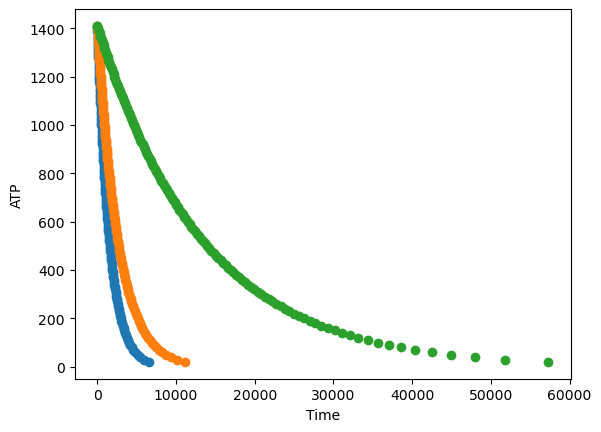

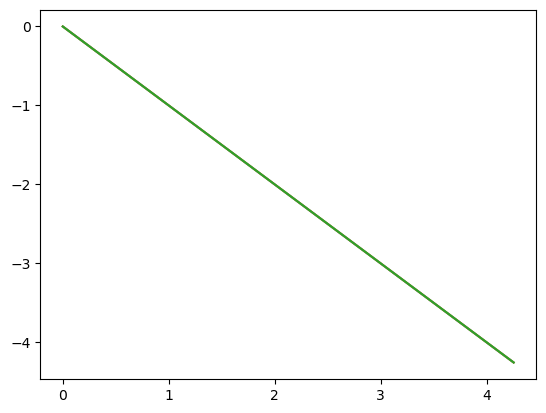

In [15]:
Keff = lambda KT, KD, KP, y0, ADP0, P0: KT*(1 + (y0 + ADP0)/KD + (y0 + P0)/KP)/((1/KT) - (1/KD) - (1/KP));
Ktime = lambda KT, KD, KP, y0, ADP0, P0, gamma, m: KT*(1 + (y0 + ADP0)/KD + (y0 + P0)/KP)/(gamma*m);
theoretical_time = lambda y, K_eff, K_time, y0: K_time*((y0 - y)/K_eff + np.log(y0/y)) 

KT = 50; 
KD = 50; 
KP = 1000; 
# Plot theoretical curve for some parameter values; 
K_eff1 = Keff(KT = KT, KD = KD, KP = KP, y0 = 1410, ADP0 = 0, P0 = 0)
K_time1 = Ktime(KT = KT, KD = KD, KP = KP, y0 = 1410, ADP0 = 0, P0 = 0, gamma = 1, m = 1)

y = np.arange(1410, 10, -10)
times1 = theoretical_time(y, K_eff1, K_time1, y0 = 1410)

KT = 500; 
KD = 500; 
KP = 1000; 
# Plot theoretical curve for some parameter values; 
K_eff2 = Keff(KT = KT, KD = KD, KP = KP, y0 = 1410, ADP0 = 0, P0 = 0)
K_time2 = Ktime(KT = KT, KD = KD, KP = KP, y0 = 1410, ADP0 = 0, P0 = 0, gamma = 1, m = 1)

times2 = theoretical_time(y, K_eff2, K_time2, y0 = 1410)

KT = 5000; 
KD = 5000; 
KP = 1000; 
# Plot theoretical curve for some parameter values; 
K_eff3 = Keff(KT = KT, KD = KD, KP = KP, y0 = 1410, ADP0 = 0, P0 = 0)
K_time3 = Ktime(KT = KT, KD = KD, KP = KP, y0 = 1410, ADP0 = 0, P0 = 0, gamma = 1, m = 1)

times3 = theoretical_time(y, K_eff3, K_time3, y0 = 1410)

plt.scatter(times1, y);
plt.scatter(times2, y); 
plt.scatter(times3, y); 

plt.ylabel("ATP")
plt.xlabel("Time")

plt.figure()
z = (y - 1410)/K_eff + np.log(y/1410)
plt.plot(times1/K_time1, z)
plt.plot(times2/K_time2, z)
plt.plot(times3/K_time3, z)


## Inference with data = $\{y_i\}$

#### Inference Model

Parameters to estimate: $\theta = (\gamma, K_T, K_D, K_P)$

Given the transcendal nature of the LHS of the equation, we are going to reformulate the problem such that t = f(y).$

To construct a likelihood, we need to transform the non-dimensionalised equation such that our parameters are on the RHS. This gives us: 

\begin{align}
t = f_{\theta}(y) = K_{time}(\,\, \frac{y(0) - y}{K_{eff}} + ln(\frac{y(0)}{y}) \,\,)
\end{align}

Assume a lognormal likelihood to begin with (that is, the time is log-normally distributed around what the theoretical time should be at the measured ATP (y)).

\begin{align}
ln(t_i) \sim Norm( \,\, ln \,\,( f_{\theta}(y_i) ), \sigma_m \,\,)\,\, \forall \,\, i
\end{align}

Now, let's assume some weakly non-informative priors on $\theta$: 

\begin{align}
&\log_{10}\gamma \sim \text{Norm}(1, 0.5),\\[1em]
&\log_{10}K_T \sim \text{Norm}(3, 1.5),\\[1em]
&\log_{10}K_D \sim \text{Norm}(3, 1.5),\\[1em]
&\log_{10}K_P \sim \text{Norm}(3, 1.5),\\[1em]
&\sigma_m \sim \text{HalfNorm}(60),\\[1em]
\end{align}


### Single Experiment

Let's begin with the ATP data only. 
That is, initial [ATP] is varied.  

General structure and approach to stan file: 

Each datapoint in $\textit{each curve}$ is treated separately. 

In [4]:
# Load stan file 
sm = cmdstanpy.CmdStanModel(stan_file='hydro-estimation.stan')

print(sm.code())

functions {
  real time_theor(
    real atp,       // atp probe data
    real time,      // time probe data
    real atp0,      // initial atp concentration
    real adp0,      // initial adp concentration
    real p0,        // initial phosphate concentration 
    real KT,       
    real KD,
    real KP,
    real gamma) {

    // Theoretical result converting time to ATP
    real m = 1; // motor concentration explicitly coded here since it's constant. Can make this varied if data for multiple motor concentrations is collected.
    real keff = KT * ( 1 + ( atp0 + adp0 ) / KD + ( atp0 + p0 ) / KP ) / ( (1/KT) - (1/KD) - (1/KP) );
    real ktime = ((1/KT) - (1/KD) - (1/KP)) * keff / ( gamma * m );
    real result = ktime * ( ( ( atp0 - atp ) / keff ) +  log(atp0/atp) );

    return result <= 0 ? 0.00001 : result;
  }
}

data {
  int N;                     // Total number of data points over entire data set (number of curves * number of data points per curve)
  // array[N] int condition;

Generating the data structure for the stan code: 

In [5]:
n1 = 10; 
n2 = 11; 
ATP_curve_list = ATP_curve_list[n1:n2]
ATP_conc_list = ATP_conc_list[n1:n2]
ADP_conc_list = ADP_conc_list[n1:n2]
P_conc_list = P_conc_list[n1:n2]
times_list = times_list[n1:n2]

flattened_ATP = [item for curve in ATP_curve_list for item in curve]; 
flattened_time = [item for curve in times_list for item in curve]; 
flattened_ATP0 = [atp0 for i, atp0 in enumerate(ATP_conc_list) for _ in range(len(ATP_curve_list[i]))]
flattened_ADP0 = [atp0 for i, atp0 in enumerate(ADP_conc_list) for _ in range(len(ATP_curve_list[i]))]
flattened_P0 = [atp0 for i, atp0 in enumerate(P_conc_list) for _ in range(len(ATP_curve_list[i]))]

data = {
    'N': sum([len(curve) for curve in ATP_curve_list]), #total number of datapoints
    'atp' : flattened_ATP, 
    'time': flattened_time,
    'atp0': flattened_ATP0,
    'adp0': flattened_ADP0,
    'p0': flattened_P0,
    # 'speed': df_exp['speed (nm/s)'].values,
}

# print(data)


# data {
#   int N;                     // Total number of data points over entire data set (number of curves * number of data points per curve)
#   // array[N] int condition;
#   array[N] real atp; 
#   array[N] real time; 
#   array[N] real atp0;
#   array[N] real adp0;
#   array[N] real p0;
#   // array[N] real speed;
# }


Sampling using Stan: 

In [6]:
samples = sm.sample(data=data, show_console = False)
samples = az.from_cmdstanpy(samples)

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

In [7]:
bebi103.stan.check_all_diagnostics(samples)

ESS for parameter log_KT is 19.66236459087011.
tail-ESS for parameter log_KT is 50.02839140858883.
ESS for parameter log_KD is 135.2407676579828.
tail-ESS for parameter log_KD is 311.12858584251063.
ESS for parameter log_KP is 19.947125401525373.
tail-ESS for parameter log_KP is 80.53682541692032.
ESS for parameter log_gamma is 19.479055071891523.
tail-ESS for parameter log_gamma is 51.455040626470385.
ESS for parameter sigma_t is 5.565417302666536.
tail-ESS for parameter sigma_t is 21.139996096656507.
ESS for parameter sigma is 9.941591098771607.
tail-ESS for parameter sigma is 101.14559487305793.
ESS for parameter ln_time[0] is 126.67217752843781.
tail-ESS for parameter ln_time[0] is 63.7978588744943.
ESS for parameter ln_time[1] is 213.88701460680448.
tail-ESS for parameter ln_time[1] is 144.78336042186297.
ESS for parameter ln_time[2] is 194.19615393402347.
tail-ESS for parameter ln_time[2] is 215.1343665998723.
ESS for parameter ln_time[3] is 120.86039295566827.
tail-ESS for param

31

In [8]:
plots = [
    iqplot.histogram(
        samples.posterior[param].values.ravel(),
        q=param,
        rug=False,
        frame_height=200,
        frame_width=250,
    )
    for param in ["KT", "KD", "KP", "gamma"]
]

bokeh.io.show(bokeh.layouts.gridplot(plots, ncols=4))

# print(len(samples.posterior["KT"].values.ravel()))

ValueError: Maximum allowed size exceeded

In [ ]:
bokeh.io.show(
    bebi103.viz.corner(
        samples,
        parameters=[
            ("gamma", "gamma (1/s)"),
            # ("KT", "KT (µM)"),
            # ("KD", "KD (µM)"),
            # ("KP", "KP (µM)"),
        ],
        xtick_label_orientation=np.pi / 4,
    )
)

In [ ]:
kwargs = dict(x_axis_type='log')
p1 = iqplot.ecdf(samples.posterior.KT.values.flatten(), x_axis_label='KT (µM)', **kwargs)
p2 = iqplot.ecdf(samples.posterior.KD.values.flatten(), x_axis_label='KD (µM)', **kwargs)
p3 = iqplot.ecdf(samples.posterior.KP.values.flatten(), x_axis_label='KP (µM)', **kwargs)
p4 = iqplot.ecdf(samples.posterior.gamma.values.flatten(), x_axis_label='Gamma (1/s)', **kwargs)


bokeh.io.show(bokeh.layouts.column(p1, p2, p3, p4))

# bokeh.io.show(p1)
# bokeh.io.show(p2)
# bokeh.io.show(p3)
# bokeh.io.show(p4)



In [ ]:
print(samples.sample_stats
)

## Inference with data = $\{t_i\}$

Considering a time shift factor $\tau$, the model becomes: 


\begin{align}
K_{eff} = \frac{K_T*(1 + \frac{y_o + ADP_o}{K_D} + \frac{y_o + P_o}{K_P})}{\frac{1}{K_T} - \frac{1}{K_D} - \frac{1}{K_P}} \,,
\end{align}

\begin{align}
\hat{t} = \frac{(t + \tau)* \gamma*m}{K_T*(1 + \frac{y_o + ADP_o}{K_D} + \frac{y_o + P_o}{K_P})} \,,
\end{align}

\begin{align}
\hat{y} = \frac{y}{K_{eff}} \,,
\end{align}

leading to the following non-dimensionalised equation: 

\begin{align}
\frac{d\hat{y}}{d\hat{t}} = - \frac{\hat{y}}{1 + \hat{y}} \,,
\end{align}


#### Inference Model

Parameters to estimate: $\theta = (K_T, K_D, K_P, \gamma, \tau)$

Given the transcendal nature of the LHS of the equation, we are going to reformulate the problem such that t = f(y).$

To construct a likelihood, we need to transform the non-dimensionalised equation such that our parameters are on the RHS. This gives us: 

\begin{align}
\frac{t + \tau}{K_{time}} = f_{\theta}(y) = \frac{y(0) - y}{K_{eff}} + ln(y(0)) - ln(y)
\end{align}

Consider input data $\{z_i\}$ s.t. $z_i = y + ln(y)$. The theoretical equations become: 

\begin{align}
\frac{t + \tau}{K_{time}}  = \,\, \hat{y}(0) - \hat{y} + ln(\frac{y(0)}{y}) = z\,\,
\end{align}


Assume a normal likelihood to begin with. 

\begin{align}
ln(z_i) \sim Norm( \,\, ln \,\,( \frac{t_i + \tau}{K_{time}} ), \sigma_m \,\,)\,\, \forall \,\, i
\end{align}

Now, let's assume some weakly non-informative priors on $\theta$: 

\begin{align}
&\log_{10}\gamma \sim \text{Norm}(1, 0.5),\\[1em]
&\log_{10}K_T \sim \text{Norm}(3, 1.5),\\[1em]
&\log_{10}K_D \sim \text{Norm}(3, 1.5),\\[1em]
&\log_{10}K_P \sim \text{Norm}(3, 1.5),\\[1em]
&\log_{10}\tau \sim \text{Norm}(3, 1.5),\\[1em]
&\sigma_m \sim \text{HalfNorm}(60),\\[1em]
\end{align}


In [9]:
# Load stan file 
sm = cmdstanpy.CmdStanModel(stan_file='hydro-estimation.stan')

print(sm.code())

functions {
  real time_theor(
    real atp,       // atp probe data
    real time,      // time probe data
    real atp0,      // initial atp concentration
    real adp0,      // initial adp concentration
    real p0,        // initial phosphate concentration 
    real KT,       
    real KD,
    real KP,
    real gamma) {

    // Theoretical result converting time to ATP
    real m = 1; // motor concentration explicitly coded here since it's constant. Can make this varied if data for multiple motor concentrations is collected.
    real keff = KT * ( 1 + ( atp0 + adp0 ) / KD + ( atp0 + p0 ) / KP ) / ( (1/KT) - (1/KD) - (1/KP) );
    real ktime = ((1/KT) - (1/KD) - (1/KP)) * keff / ( gamma * m );
    real result = ktime * ( ( ( atp0 - atp ) / keff ) +  log(atp0/atp) );

    return result <= 0 ? 0.00001 : result;
  }
}

data {
  int N;                     // Total number of data points over entire data set (number of curves * number of data points per curve)
  // array[N] int condition;

In [10]:
# Load stan file 
sm = cmdstanpy.CmdStanModel(stan_file='hydro-estimation-z.stan')

print(sm.code())

functions {
  // Used in likelihood
  real z_theor(
    real atp,       // atp probe data
    real time,      // time probe data
    real atp0,      // initial atp concentration
    real adp0,      // initial adp concentration
    real p0,        // initial phosphate concentration 
    real KT,       
    real KD,
    real KP,
    real gamma, 
    real tau) {

    // Theoretical result converting time to ATP
    real m = 1; // motor concentration explicitly coded here since it's constant. Can make this varied if data for multiple motor concentrations is collected.
    real keff = KT * ( 1 + ( atp0 + adp0 ) / KD + ( atp0 + p0 ) / KP ) / ( (1/KT) - (1/KD) - (1/KP) );
    real ktime = ((1/KT) - (1/KD) - (1/KP)) * keff / ( gamma * m );

    real result = (time + tau)/ktime - (atp - atp0)/keff;

    return result <= 0 ? 0.00001 : result;
  }

}

data {
  int N;                     // Total number of data points over entire data set (number of curves * number of data points per curve)
  // a

In [11]:
n1 = 1; 
n2 = 6; 
ATP_curve_list_select = ATP_curve_list[n1:n2]
ATP_conc_list_select = ATP_conc_list[n1:n2]
ADP_conc_list_select = ADP_conc_list[n1:n2]
P_conc_list_select = P_conc_list[n1:n2]
times_list_select = times_list[n1:n2]
print('concs: ', ATP_conc_list_select)
# Transformed variable 
# print(ATP_curve_list_select[0], ATP_conc_list[0])
log_atp_nd_list = []
for i in np.arange(n1,n2,1):
    print(i-1)
    # print(ATP_conc_list[i])
    # print(np.any(ATP_curve_list_select[i]/ATP_conc_list[i] == np.inf))
    # print(ATP_curve_list[i]/ATP_conc_list[i])
    log_atp_nd = np.log(ATP_curve_list_select[i-1]/ATP_conc_list_select[i-1])
    log_atp_nd_list.append(log_atp_nd)
print(len(ATP_curve_list_select), len(log_atp_nd_list))
flattened_ATP = np.array([item for curve in ATP_curve_list_select for item in curve]); 
flattened_log_atp_nd = np.array([item for curve in log_atp_nd_list for item in curve]);
flattened_time = np.array([item for curve in times_list_select for item in curve]); 
flattened_ATP0 = np.array([atp0 for i, atp0 in enumerate(ATP_conc_list_select) for _ in range(len(ATP_curve_list_select[i]))])
flattened_ADP0 = np.array([atp0 for i, atp0 in enumerate(ADP_conc_list_select) for _ in range(len(ATP_curve_list_select[i]))])
flattened_P0 = np.array([atp0 for i, atp0 in enumerate(P_conc_list_select) for _ in range(len(ATP_curve_list_select[i]))])

# selected_data = list(set(np.concatenate(np.where(flattened_ATP0 != 0)[-1], np.where(log_atp_nd_list != np.nan)[-1]))); 
# selected_data = np.concatenate((np.where(flattened_ATP0 != 0)[-1], np.where(log_atp_nd_list != np.inf)[-1])); 
# print('inf', np.where(log_atp_nd_list != np.inf)[-1])
# selected_data.sort()
# print(len(flattened_ATP), len(flattened_log_atp_nd))
# print(len*see)

data = {
    'N': len(flattened_ATP[:]), #total number of datapoints
    'atp' : flattened_ATP[:],
    'log_atp_nd' : flattened_log_atp_nd[:],
    'time': flattened_time[:],
    'atp0': flattened_ATP0[:],
    'adp0': flattened_ADP0[:],
    'p0': flattened_P0[:]
    # 'speed': df_exp['speed (nm/s)'].values,
}

print(data['log_atp_nd'])

concs:  []
0


IndexError: list index out of range

In [ ]:
a = np.array([1,2,3])
b = np.array([4,2,3])
# a.concatenate(b)
c = np.concatenate((a,b))
c
c.sort()
list(set(c))

In [ ]:
samples = sm.sample(data=data, show_console = False)
samples = az.from_cmdstanpy(samples)

In [ ]:
bebi103.stan.check_all_diagnostics(samples)

In [ ]:
plots = [
    iqplot.histogram(
        samples.posterior[param].values.ravel(),
        q=param,
        rug=False,
        frame_height=200,
        frame_width=250,
    )
    for param in ["gamma"]
]

bokeh.io.show(bokeh.layouts.gridplot(plots, ncols=4))

# print(len(samples.posterior["KT"].values.ravel()))